# Анализ временных рядов с помощью моделей семейства SARIMA

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings

In [142]:
warnings.filterwarnings('ignore')

In [110]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


#### Анализ проведем на примере временного ряда концентрации CO2 в период 1965 - 1981гг

In [111]:
data = pd.read_csv('co2-ppm.csv', sep =',', index_col=['Month'], parse_dates=['Month'])

In [112]:
data.columns = ['CO2']

In [113]:
data.head(5)

,CO2
Month,
1965-01-01,319.32
1965-02-01,320.36
1965-03-01,320.82
1965-04-01,322.06
1965-05-01,322.17


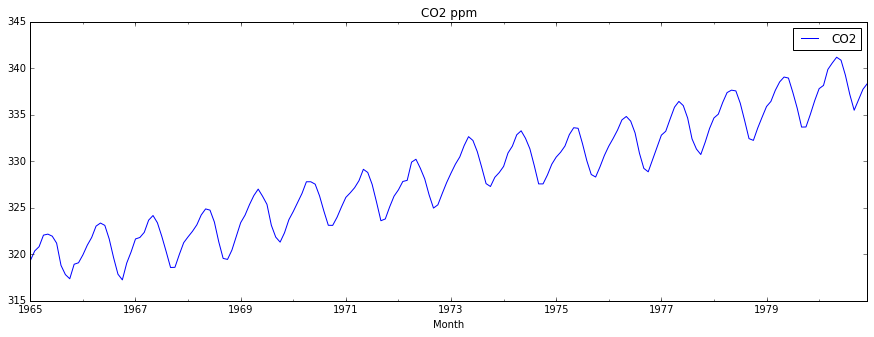

In [114]:
plt.figure(figsize(15,5))
data.plot(title= 'CO2 ppm')

## Основные компоненты временных рядов

<p><br>
- ** Тренд ** - плавное долгосрочное изменение уровня ряда


- ** Сезонность ** - циклические изменения уровня ряда с *** постоянным периодом ***


- ** Цикл ** - циклические изменения уровня ряда с *** переменным периодом ***


- ** Ошибка ** - непрогнозируемая случайная компонента ряда



### STL -декомпозиция ряда на составляющие (Seasonal and Trend decomposition using Loess)*
<small>* LOESS is a method for fitting a smooth curve between two variables, or fitting a smooth surface between an outcome and up to four predictor variables.

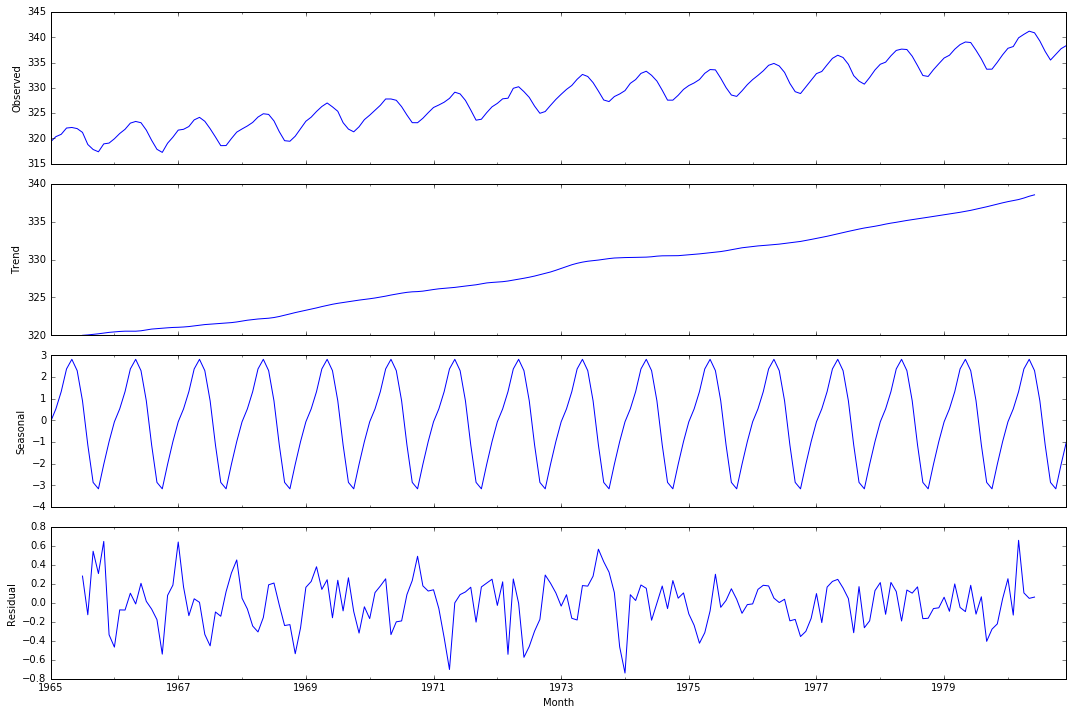

In [115]:
import statsmodels.api as sm
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data).plot()
pylab.show()

### Основное предположение
 ***В задаче анализа временных рядов предполагается, что данные в прошлом каким-то образом связаны с данными в будущем***


## Основные характеристики временных рядов
### 1. Автокорреляция

Количественная характеристика сходства между значениями ряда в соседних точках вычисляется с помощью автокорреляционной функции:


$$r_\tau = \frac{ \mathbf{E} ((y_t - \mathbf{E}y)(y_{t+\tau} - \mathbf{E}{y}))}{\mathbf{D}{y}}$$ 


-корреляция Пирсона между исходным рядом и его версией, сдвинутой но несколько отсчетов - лагов автокорреляции ($\tau $)

При вычислении на выборке - заменяем математическое ожидание на выборочное среднее, дисперсию на выборочную дисперсию:

$$r_\tau = \frac{ \sum_{t=1}^{T-\tau} (y_t - \overline{y})(y_{t+\tau} - \overline{y})} {\sum_{t=1}^{T-\tau} (y_t-\overline{y})^2}$$ 



### Строим коррелограмму
-график зависимости величины автокорреляции от разных значений лагов

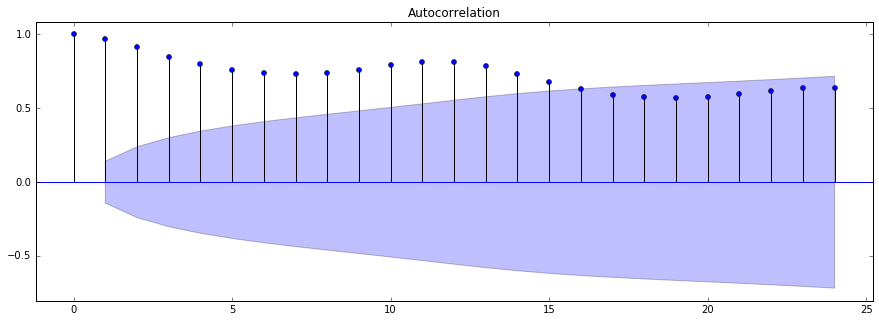

In [116]:
plt.figure(figsize(15,5))
sm.graphics.tsa.plot_acf(data.values, lags=24)
pylab.show()

На графике видно, что автокорреляция принимает большие значения
в лагах, кратных сезонному периоду.

Выделенный  коридор - это коридор значимости отличия корреляции от нуля (вычисляется с помощью критерия Стьюдента).



### 2. Стационарность

 Под стационарностью понимают свойство процесса не менять своих статистических характеристик с течением времени, а именно постоянство матожидания, постоянство дисперсии (она же гомоскедастичность) и независимость ковариационной функции от времени. 

Формально, временной ряд $y_1,.....y_T$  называется стационарным если для любого окна, шириной s распределение $y_t,.....y_{t+s}$ не зависит от t.

- ряд с трендом - нестационарен
- ряд с сезонностью - нестационарен
- ряд с изменяемой дисперсией - нестационарен

#### Проверка ряда на стационарность 
Формально гипотезу о стационарности можно проверить с помощью критерия Дики-Фуллера:
- нулевая гипотеза $H_0$:  ряд нестационарен
- альтернатива $H_1$: ряд стационарен

In [117]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['CO2'])[1])

Критерий Дики-Фуллера: p=0.996434


#### Делаем из нестационарного ряда - стационарный
** 1) Стабилизация дисперсии **

Если во временном ряде монотонно по времени изменяется дисперсия, применяется
специальное преобразование, стабилизирующее дисперсию - преобразование Бокса - Кокса. Это параметрическое преобразование и в зависимости от параметра $\lambda$ может быть: 
 - логарифмированием ($\lambda$ = 0)
 - тождественным преобразованием ($\lambda$ = 1)
 - степенным преобразованием (при других значениях ($\lambda$ = 1))
 
В scipy.stats есть удобная функция которая вычисляет оптимальный параметр $\lambda$ и производит соответствующее преобразование:



Оптимальный параметр преобразования Бокса-Кокса: -1.942333
Критерий Дики-Фуллера: p=0.991760


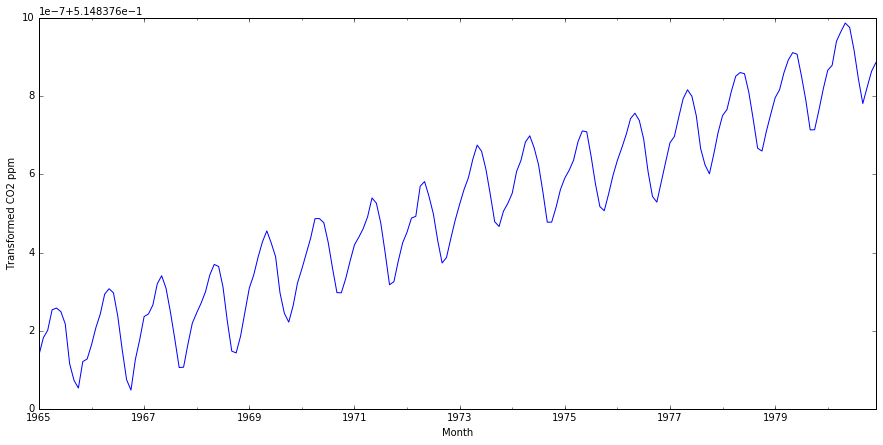

In [118]:
from scipy import stats

data['CO2_box'], lmbda = stats.boxcox(data.CO2)
plt.figure(figsize(15,7))
data.CO2_box.plot()
plt.ylabel(u'Transformed CO2 ppm')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.CO2_box)[1])


Критерий Дики-Фуллера все еще не отвергает гипотезу нестационарности, визуально в данных виден тренд и сезонность. 

### 2) Избавляемся от тренда и сезонности

Стабилизировать среднее значение ряда (избавится от тренда и сезонности) помогает переход к попарным разностям соседних(для избавления от тренда) или кратных периоду сезонности (для избавления от сезонности) значений:
$$ y' = y_t-y_{t-1}$$

Такая операция над рядом называется дифференцированием и может применятся неоднократно.
Сезонное и обычное дифференцирование могут применяться к ряду в любом порядке. Однако если у ряда
есть ярко выраженный сезонный профиль, то рекомендуется начинать с сезонного дифференцирования, уже
после такого преобразования может оказаться, что ряд стационарен.



Попробуем сезонное дифференцирование, сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.055443


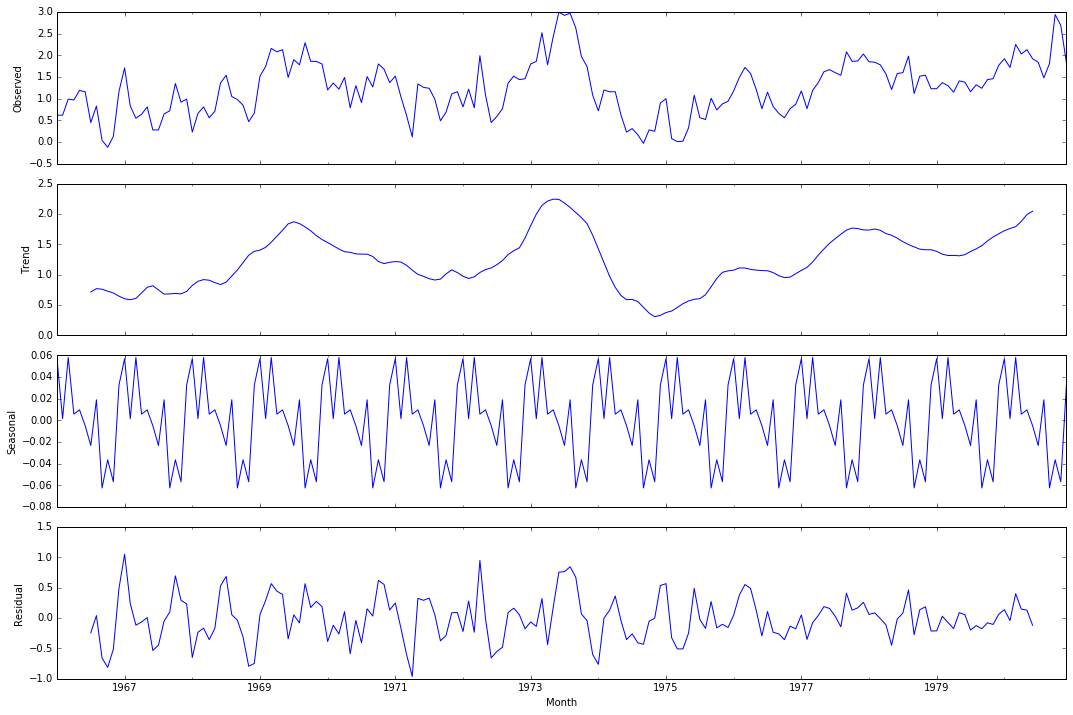

In [119]:
data['CO2_diff'] = data.CO2 - data.CO2.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.CO2_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.CO2_diff[12:])[1])

Критерий Дики-Фуллера значительно уменьшился но все еще не отвергает гипотезу нестационарности (для p-value = 0.05). Тренд еще просматривается.

Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000008


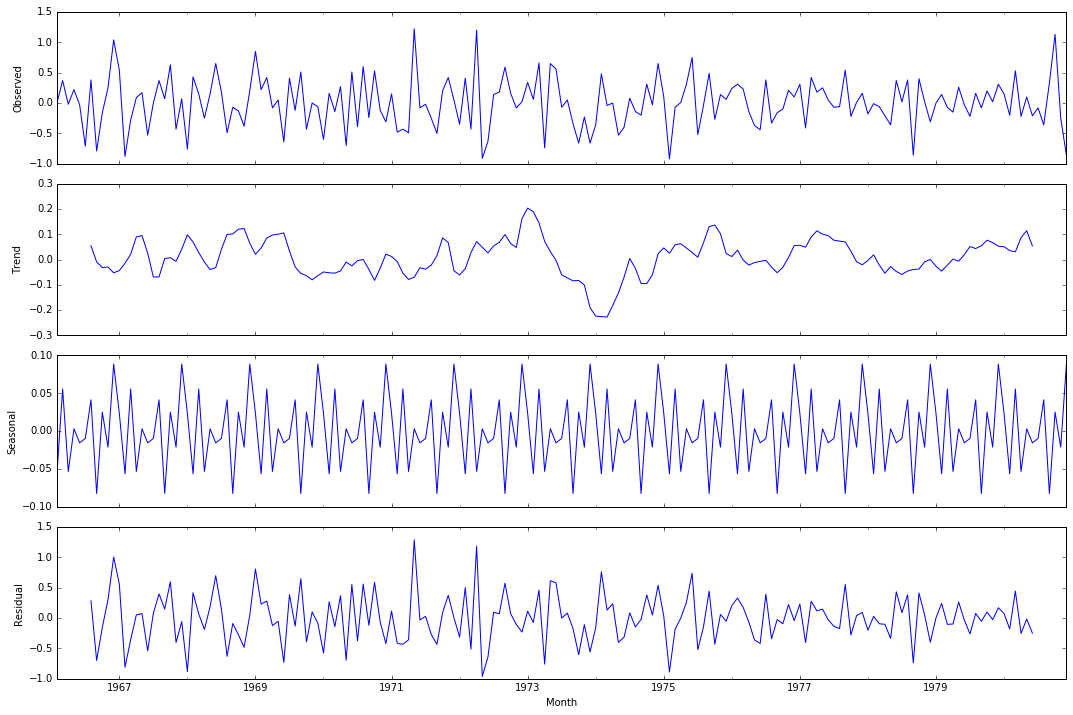

In [120]:
data['CO2_diff2'] = data.CO2_diff - data.CO2_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.CO2_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.CO2_diff2[13:])[1])

Видно что ряд стационарен, это подтверждается и формальным критерием.

## Прогнозирующая модель SARIMA 
### 1. Авторегрессионная компонента (AR)

** Как построить прогнозирующую модель временного ряда? **
- построить модель регрессии на каких-то признаках

**На каких признаках? **


 - признаки зависящие от времени  - низкое качество
 - собственные значения ряда в прошлом:
$$ y_t = \alpha + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t $$

$\alpha, \phi_1, .. \phi_p $ - параметры модели, которые необходимо оценить, $\epsilon_t $ - шумовая компонента, описывает отклонения значений рада от данного уравнения.

** Такая модель называется моделью *авторегрессии* порядка p AR(p))**

            


### 2. Скользящее среднее (MA)

Построим график независимого, одинаково распределенного во времени шума $\epsilon_t $

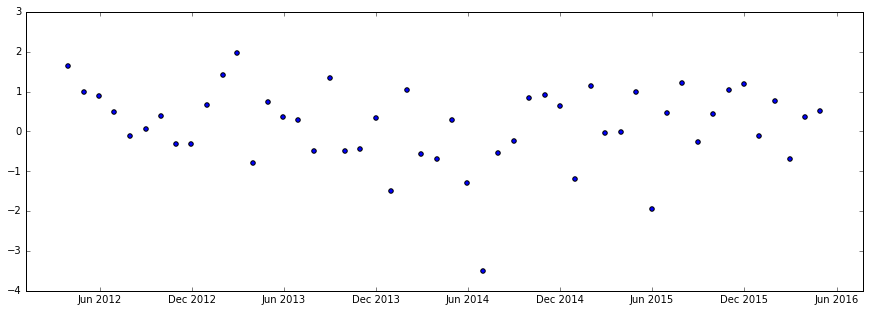

In [143]:
plt.figure(figsize=(15,5))
rng = pd.date_range('3/6/2012', periods=50, freq='m')
noise = pd.Series(np.random.normal(size=50),rng)
plt.scatter(x = rng, y = noise)

Для каждого значения t можно вычислить среднее арифметическое между точками $\epsilon_t$ и $\epsilon_{t−1}$


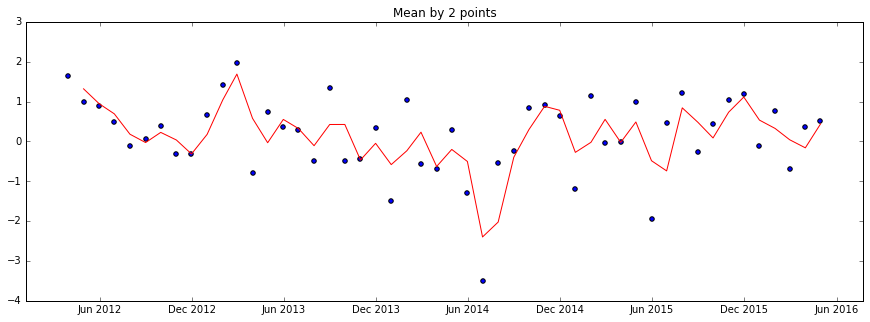

In [144]:
# pandas should be version > 0.18.0.

plt.figure(figsize=(15,5))
plt.scatter(x  = rng, y = noise)
avr_2 = noise.rolling(2).mean()
plt.plot(avr_2[1:], color = 'r')
plt.title("Mean by 2 points")
pylab.show()

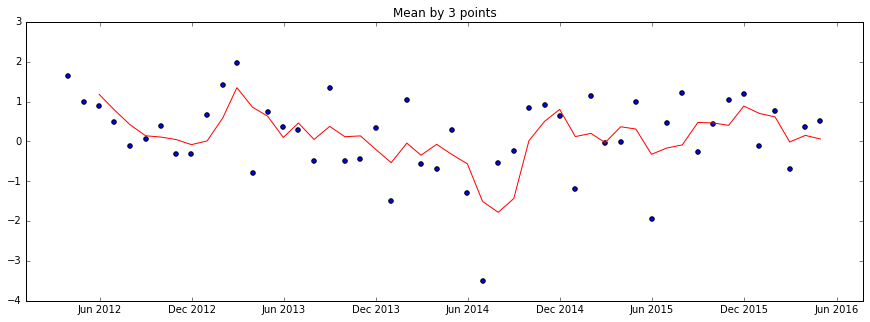

In [145]:
plt.figure(figsize=(15,5))
plt.scatter(x  = rng, y = noise)
avr_2 = noise.rolling(3).mean()
plt.plot(avr_2[2:], color = 'r')
plt.title("Mean by 3 points")
pylab.show()

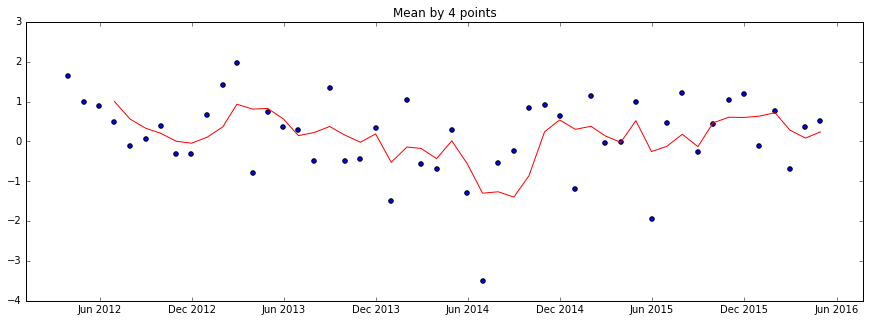

In [146]:
plt.figure(figsize=(15,5))
plt.scatter(x  = rng, y = noise)
avr_2 = noise.rolling(4).mean()
plt.plot(avr_2[2:], color = 'r')
plt.title("Mean by 4 points")
pylab.show()

Можно записать следующую модель ряда:
    $$ y_t = \alpha + \epsilon_t +  \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q} $$ 
    
Такая модель называется моделью скользящего среднего порядка q
(MA(q)). В ней предполагается, что значение ряда $y_t$ — это линейная комбинация q последних значений
шумовой компоненты.

    

### 3. ARMA

**ARMA(p,q)** - объединение авторегрессионной модели порядка р (AR(p), и модели скользящего среднего(MA(q)):

$$ y_t = \alpha + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q} $$ 

*** Теорема Вольда утверждает, что любой стационарный временной
ряд может быть описан моделью ARMA(p,q) с правильным подбором значений параметров p,q.***

### 4. ARIMA
Как уже отмечалось выше, с помощью диференцирования можно нестационарный ряд сделать стационарным.
Модель **ARIMA(p,d,q) ** - это модель ARMA(p,q) для d раз продифференциованого  ряда.

### 5. SARIMA
**Учет сезонной компоненты**

Если ряд имеет сезонный период длины S, к модели ARMA(p,q) можно добавить P авторегрессионных компонент, но не предыдущих а с шагом равным периоду сезонности:

$$ +  \phi_S y_{t-1} + \phi_2S y_{t-2} + ... + \phi_PS y_{t-PS} $$

и Q компонент скользящего среднего, с таким же шагом:

$$ + \theta_S \epsilon_{t-1} + \theta_2S \epsilon_{t-2S} + ... + \theta_QS \epsilon_{t-QS} $$ 

Полученная модель - модель **SARIMA(p,d,q) x (P,D,Q)**


## Подбор параметров модели
 - Параметры d,D,q,Q,p,P - гиперпараметры, определяют структуру и количество коэффициентов модели ARIMA
 - $ \alpha, \phi, \theta $ - подбираются с помощью оптимизации, например, методом наименьших квадратов
 

#### Параметры d, D
Параметры d, D, которые задают порядки дифференцирования, необходимо подбирать так, чтобы ряд стал
стационарным.

Для нашей задачи  d = 1, D = 1


#### Параметры q, Q, p, P
Чем больше значение этих параметров - тем больше компонент в регрессионном уравнении модели - тем она сложнее - тем лучше подстраивается под данные, но не будет оптимальной. Оптимальной моделью будет модель которая дает хорошее качество правдоподобия но имеет минимальное количество компонент.

Это учитывает критерий Акаике:

        AIC  = -2lnL + 2k
        
где L — правдоподобие, k=P+Q+p+q+1 — число параметров в модели.


Оптимальной будет модель с наименьшим значением этого критерия.
В конечном итоге значения параметров q, Q, p, P определяются перебором: из разных значений гиперпараметров выбираются те, у которых значение критерия Акаике будет минимальным. Начальные приближения для этого перебора можно выбрать с помощью автокорреляционной функции и частичной автокорреляционной функции.

**Частичная автокорреляция ** — это автокорреляция после снятия авторегрессии предыдущего порядка. Например, чтобы подсчитать частичную автокорреляцию с лагом τ =2, требуется построить авторегрессию порядка 1, вычесть эту авторегрессию из ряда и подсчитать автокорреляцию на полученных остатках.


Построим ACF нашего ряда после проведенного сезонного и обычного дифференцирования:


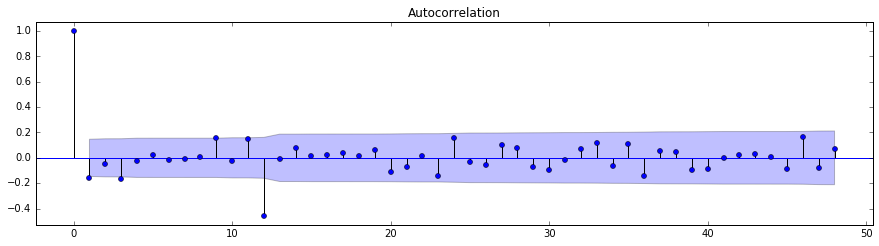

In [125]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.CO2_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальное значение для параметра Q даёт номер последнего сезонного лага, при котором
автокорреляция значима.

В рассматриваемом примере Q=1 (лаг 12 - это первый сезонный для сезона длины 12).

Параметр q задаётся номером последнего несезонного лага, при котором
автокорреляция значима. 

В данном случае можно взять начальное значение q=0.


Значения параметров p, P подбираются с использованием не автокорреляционной функции, а частичной
автокорреляционной функции.


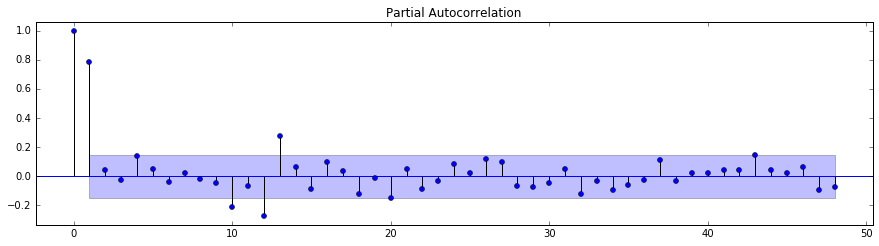

In [126]:
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.CO2_diff[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальное приближение для параметра P задаёт номер последнего сезонного лага, при котором частичная
автокорреляция значима. В данных из примера это лаг под номером 12, значит P = 1.

Аналогично, p задаётся как номер последнего несезонного
лага, при котором частичная автокорреляция значима. В данном случае можно взять начальное приближение 2.



Начальные приближения: Q=1, q=0, P=1, p=2.

Построим наборы параметров для перебора:

In [148]:
# Задаем диапазоны пареметров
ps = range(0, 3)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [128]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print("Количество параметров: {}".format(len(parameters_list)))

Количество параметров: 24


### Обучаем модель с подбором параметров

In [129]:
import warnings

In [130]:
# Attention - long execution time is possible!!!!

results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.CO2, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)


Лучший набор параметров:

In [131]:
best_param

(1, 1, 0, 1)

In [132]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())


      parameters         aic
12  (1, 1, 0, 1)  117.036356
4   (0, 1, 0, 1)  117.610144
14  (1, 1, 1, 1)  119.014391
6   (0, 1, 1, 1)  119.603879
8   (1, 0, 0, 1)  120.010793


Лучшая модель:  

In [133]:
print(best_model.summary())


                                 Statespace Model Results                                 
Dep. Variable:                                CO2   No. Observations:                  192
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 -54.518
Date:                            Tue, 27 Jun 2017   AIC                            117.036
Time:                                    09:56:47   BIC                            130.066
Sample:                                01-01-1965   HQIC                           122.314
                                     - 12-01-1980                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3715      0.186      2.001      0.045       0.008       0.735
ma.L1         -0.6709      0.159   

### Анализ остатков

Остатки должны быть:

- несмещенными
- стационарными
- неавтокоррелированными

Гипотезу о неавтокоррелированности можно проверить по коррелограмме, а также с помощью Q-критерия
Льюнг-Бокса (см. параметр Ljung-Box (Q) в таблице результатов по лучшей модели)

Автокоррелированность остатков — признак того, что в данных присутствует информация, которая не
вошла в модель


Критерий Стьюдента: p=0.212893
Критерий Дики-Фуллера: p=0.000000


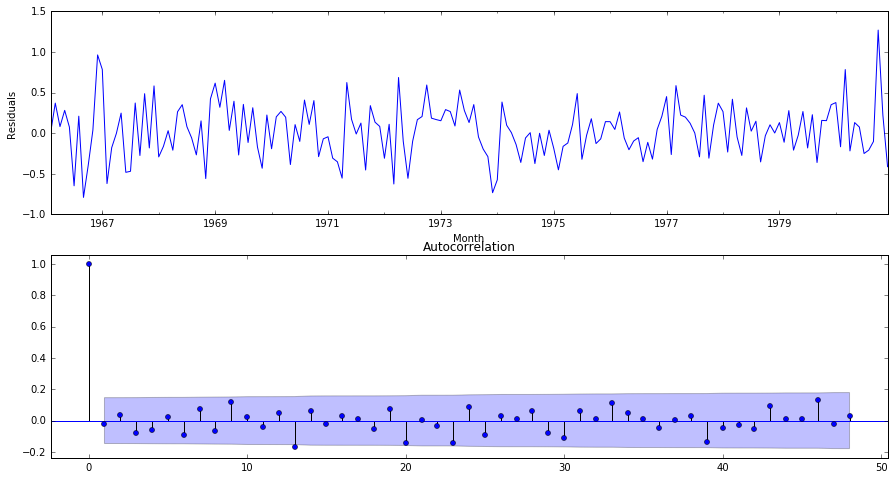

In [134]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Гипотеза о несмещенности остатков не отвергается согласно критерия Стьюдента), остатки стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнг-Бокса и коррелограммой). Посмотрим, насколько хорошо модель описывает данные:

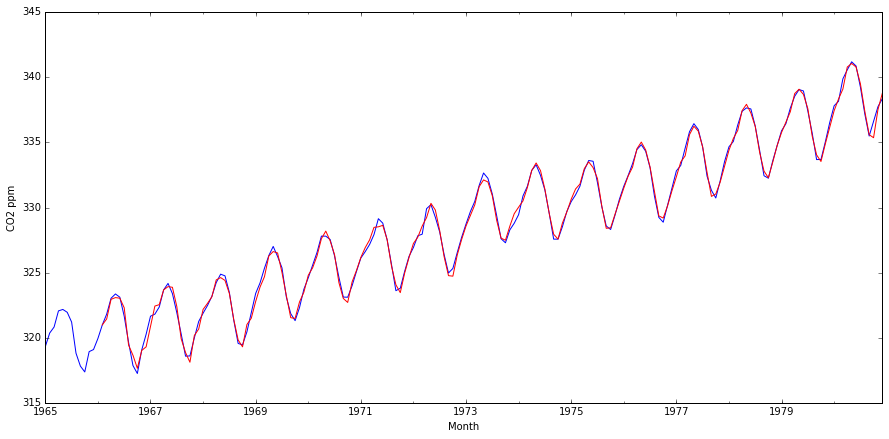

In [135]:
# Функция обратного преобразования Бокса-какса. Так как на данном примере это преобразование 
# не использовано - дается в качестве информации

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

#data['model'] = invboxcox(best_model.fittedvalues, lmbda)
data['model'] = best_model.fittedvalues
plt.figure(figsize(15,7))
data.CO2.plot()
data.model[13:].plot(color='r')
plt.ylabel('CO2 ppm')
pylab.show()

## Прогноз
    

In [136]:
#Оценим последнюю дату в наборе
data.iloc[-1]

CO2          338.360000
CO2_box        0.514838
CO2_diff       1.830000
CO2_diff2     -0.860000
model        338.773367
Name: 1980-12-01 00:00:00, dtype: float64

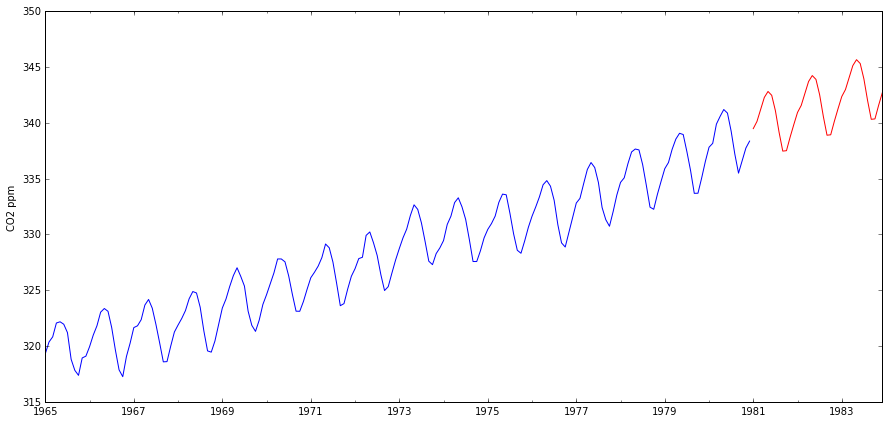

In [137]:
#Строим прогноз на 36 мес вперед
data2 = data[['CO2']]
date_list = [datetime.datetime.strptime("1981-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns = data.columns)
data2 = pd.concat([data2, future])

# in case of using box-cox: data2['forecast'] = invboxcox(best_model.predict(start=192, end=321), lmbda)

#start=192 - taken from No. Observations: 192 (best_models))

data2['forecast'] = best_model.predict(start=192, end=227)


plt.figure(figsize(15,7))
data2.CO2.plot()
data2.forecast.plot(color='r')
plt.ylabel('CO2 ppm')
pylab.show()